<a href="https://colab.research.google.com/github/ykato27/DALL-E/blob/main/DALL_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-ffadf8cc-cdf8-e949-9b49-917cea266a60)


In [2]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 71kB 5.2MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=03e5b968fca14b62ee4f369b1fc2f94dc81b95da8dd1c318a251ef8d88c5bf21
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy
     |████████████████████████████████| 21.6MB 45.9MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 747kB 39.9MB/s 
     |████████████████████████████████| 1.9MB 40.5MB/s 
     |████████████████████████████████| 143kB 40.9MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:


必要なライブラリーのインポートと関数の定義

In [3]:
import glob
import os
import random

from google.colab import output
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torchvision
import torchvision.transforms.functional as TF


InteractiveShell.ast_node_interactivity = "all"

# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape


def displ(img, pre_scaled=True):
    img = np.array(img)[:, :, :]
    img = np.transpose(img, (1, 2, 0))
    if not pre_scaled:
        img = scale(img, 48 * 4, 32 * 4)
    imageio.imwrite(str(3) + ".png", np.array(img))
    return display.Image(str(3) + ".png")


def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex // ncols
    assert nindex == nrows * ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (
        array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1, 2)
        .reshape(height * nrows, width * ncols, intensity)
    )
    return result


def card_padded(im, to_pad=3):
    return np.pad(
        np.pad(
            np.pad(im, [[1, 1], [1, 1], [0, 0]], constant_values=0),
            [[2, 2], [2, 2], [0, 0]],
            constant_values=1,
        ),
        [[to_pad, to_pad], [to_pad, to_pad], [0, 0]],
        constant_values=0,
    )


def get_all(img):
    img = np.transpose(img, (0, 2, 3, 1))
    cards = np.zeros((img.shape[0], sideX + 12, sideY + 12, 3))
    for i in range(len(img)):
        cards[i] = card_padded(img[i])
    print(img.shape)
    cards = gallery(cards)
    imageio.imwrite(str(3) + ".png", np.array(cards))
    return display.Image(str(3) + ".png")

「Perceptor」です。センテンスと画像の橋渡しをする、CLIPをモデル化

In [4]:
import clip


clip.available_models()

# Load the model
perceptor, preprocess = clip.load("ViT-B/32", jit=True)
perceptor = perceptor.eval()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

100%|███████████████████████████████████████| 354M/354M [00:15<00:00, 22.7MiB/s]


「Generator」です。画像を生成するGeneratorをモデル化

In [5]:
import io
import os
import sys

from dall_e import load_model
from dall_e import map_pixels
from dall_e import unmap_pixels
import PIL
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF


target_image_size = sideX


def preprocess(img):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f"min dim for image {s} < {target_image_size}")

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", "cuda")

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


「Text input」です。自分が画像生成したいテキストを text_input に設定します。tau_value は1.2のままで構いません（ちなみに、数字を大きくするとより創造性が高まります）。



In [6]:
text_input = "a beautiful and mysterious castle designed by Escher"
tau_value = 1.2

「Latent coordinate」です。テキストをトークンに変換

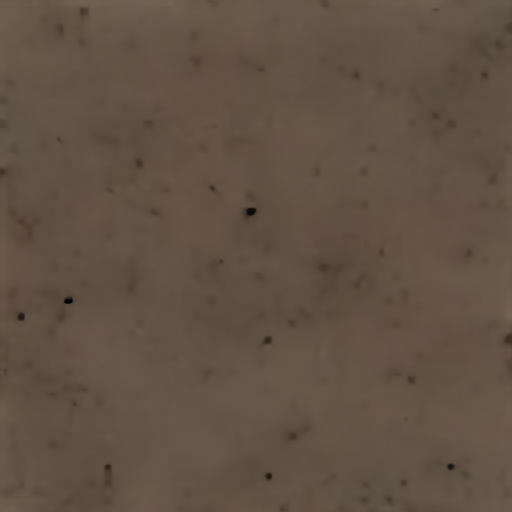

In [7]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

    def forward(self):
        # normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)
        normu = torch.nn.functional.gumbel_softmax(
            self.normu.view(1, 8192, -1), dim=-1, tau=tau_value
        ).view(1, 8192, 64, 64)
        return normu


lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{"params": mapper, "lr": 0.1}])
eps = 0
tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()
nom = torchvision.transforms.Normalize(
    (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
)

with torch.no_grad():
    mult = 1
    al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
    for allls in al:
        displ(allls[:3])
        print("\n")

「Train」です。100トライ毎に生成した画像を表示すると共に images フォルダーにその画像が保存

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


##########################################################  [0, tensor([-1.8633], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 0


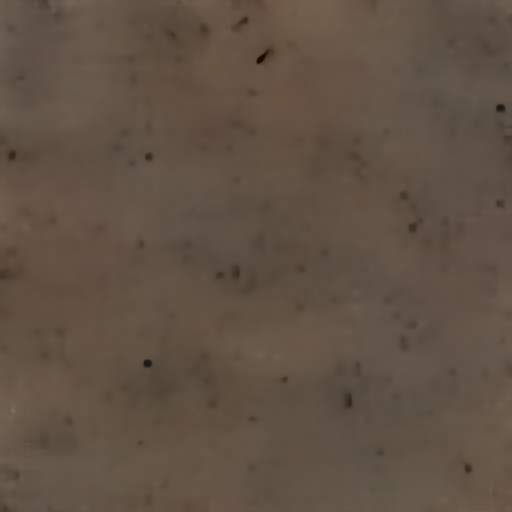



##########################################################  [0, tensor([-4.0469], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 100


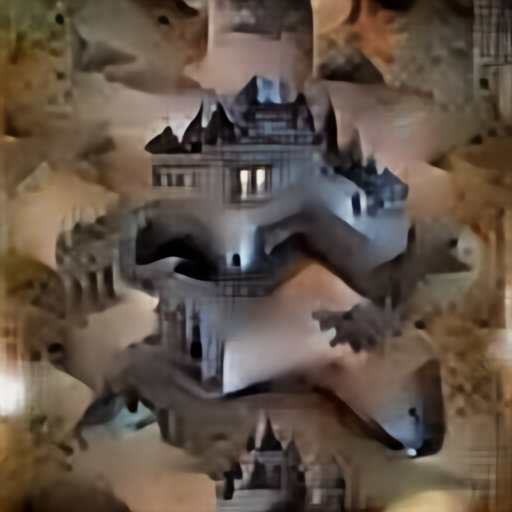



##########################################################  [0, tensor([-4.2891], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 200


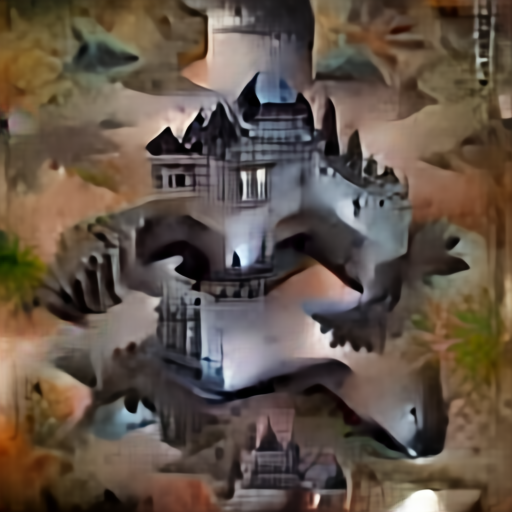



##########################################################  [0, tensor([-4.1875], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 300


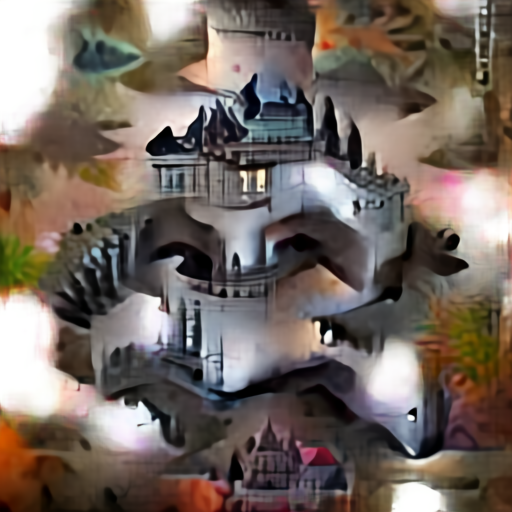



##########################################################  [0, tensor([-4.3750], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 400


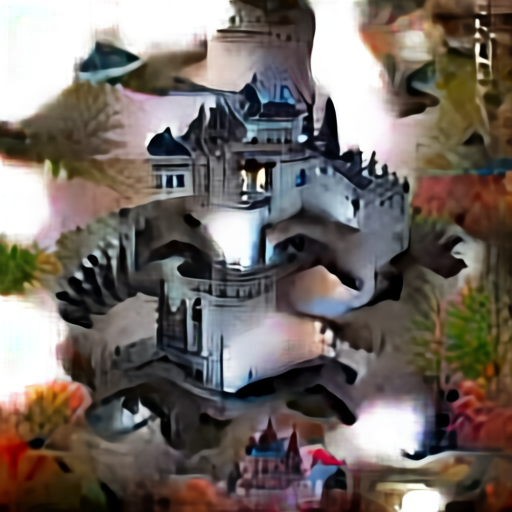



##########################################################  [0, tensor([-4.4961], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 500


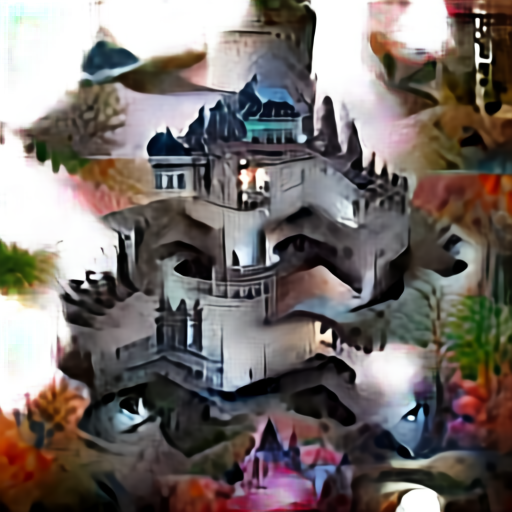



##########################################################  [0, tensor([-4.7656], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 600


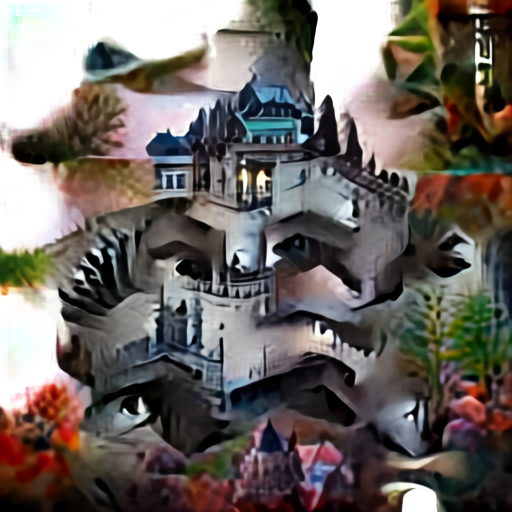



##########################################################  [0, tensor([-4.6641], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 700


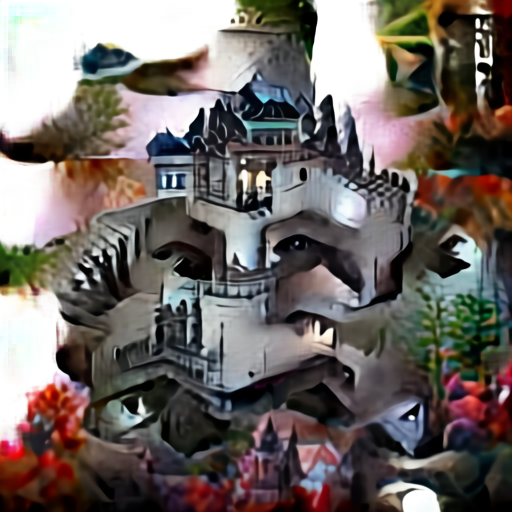



##########################################################  [0, tensor([-4.8398], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 800


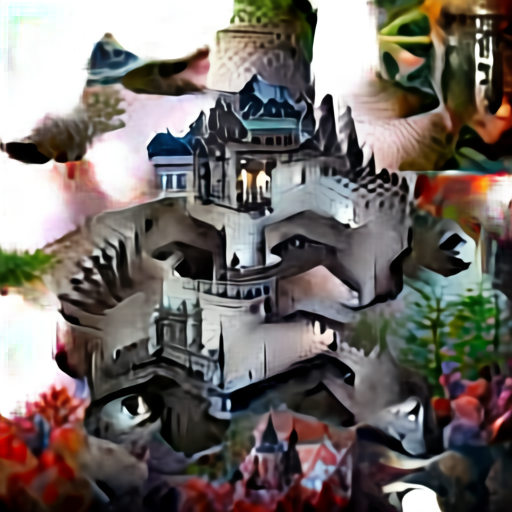



##########################################################  [0, tensor([-4.8672], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 900


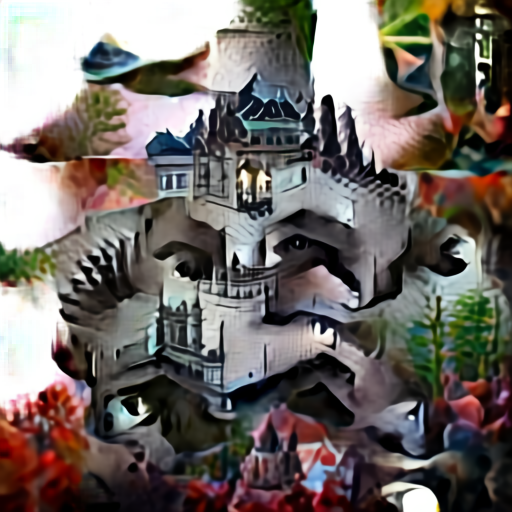



##########################################################  [0, tensor([-4.9961], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1000


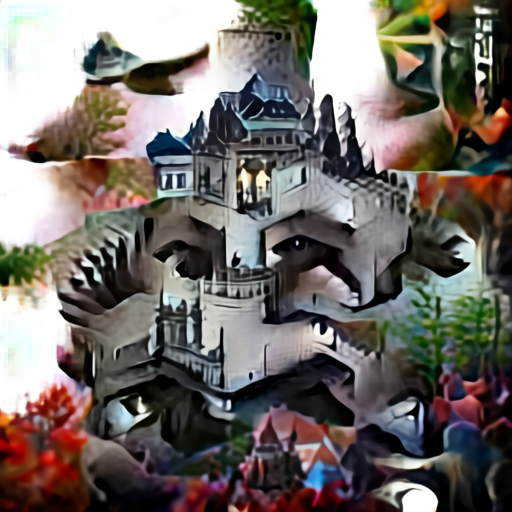

In [8]:
def checkin(loss):
    print(
        """########################################################## """,
        loss,
        "\n",
        itt,
    )

    with torch.no_grad():
        al = unmap_pixels(
            torch.sigmoid(model(lats())[:, :3]).cpu().float()
        ).numpy()
    for allls in al:
        displ(allls)
        display.display(display.Image(str(3) + ".png"))
        print("\n")
    # the people spoke and they love "ding"
    output.eval_js(
        'new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()'
    )


def ascend_txt():
    out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
    cutn = 64  # improves quality
    p_s = []
    for ch in range(cutn):
        size = int(
            sideX
            * torch.zeros(
                1,
            )
            .normal_(mean=0.8, std=0.3)
            .clip(0.5, 0.98)
        )
        offsetx = torch.randint(0, sideX - size, ())
        offsety = torch.randint(0, sideX - size, ())
        apper = out[:, :, offsetx : offsetx + size, offsety : offsety + size]
        apper = torch.nn.functional.interpolate(
            apper, (224, 224), mode="bilinear"
        )
        p_s.append(apper)
    into = torch.cat(p_s, 0)
    # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')
    into = nom(into)
    iii = perceptor.encode_image(into)
    llls = lats()
    lat_l = 0
    return [lat_l, 10 * -torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]


def train(i):
    loss1 = ascend_txt()
    loss = loss1[0] + loss1[1]
    loss = loss.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if itt % 100 == 0:
        checkin(loss1)
        shutil.copy(
            "./3.png", "./images/%s.png" % str(int(itt / 100)).zfill(6)
        )


import shutil


if os.path.isdir("images"):
    shutil.rmtree("images")
os.makedirs("images", exist_ok=True)

itt = 0
for asatreat in range(1100):
    train(itt)
    itt += 1

「Make movie」です。お好みにより、images フォルダーの画像から動画を作りたい場合は動かして下さい。-r の後の数字2はフレームレートです。

In [9]:
if os.path.exists("./output.mp4"):
    os.remove("./output.mp4")

!ffmpeg -r 2 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib